# Compute Steepness of Tiles

# table of content
1) 

### Dependencies and general utils

In [1]:
# pip install scipy

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
import laspy
# import pdal
import json
import scipy
import copy
import pickle
from tqdm import tqdm
from scipy.spatial import cKDTree
from scipy.interpolate import griddata

### Classification results

                         tile_name  garbage  multi  single
0   color_grp_full_tile_92_out.laz       35      1       2
1  color_grp_full_tile_664_out.laz       84      4      12
2  color_grp_full_tile_637_out.laz       80      0       0
3  color_grp_full_tile_671_out.laz       30      2       6
4  color_grp_full_tile_657_out.laz       29      5      12
----
Number of tiles:  701
----
Average number of singles per tile:  46
----
Average number of the 200 tiles with the most single samples:  139
----


<Axes: >

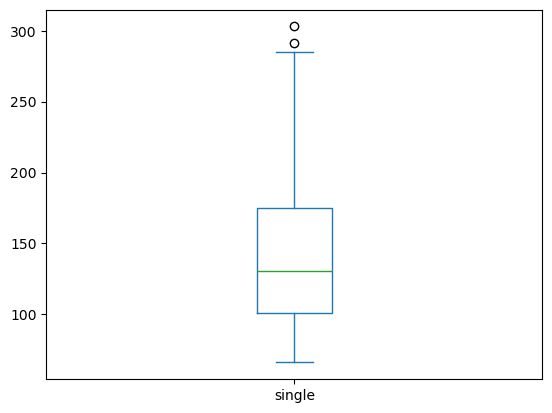

In [3]:
src_class_file = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection\distribution_per_tile.csv"
df_class_results = pd.read_csv(src_class_file, sep=';')

# number of top samples to choose
num_top_samples = 200

print(df_class_results.head())
print('----')
print("Number of tiles: ", len(df_class_results))
print('----')
print("Average number of singles per tile: ", int(df_class_results.single.aggregate('mean')))
print('----')
df_top_samples = df_class_results.sort_values('single', ascending=False).iloc[0:200]
print(f"Average number of the {num_top_samples} tiles with the most single samples: ", int(np.mean(df_top_samples.single.values)))
print('----')
# df_class_results.plot(kind='box', y='single')
df_top_samples.single.plot(kind='box')

### Load samples

In [4]:
src_tiles = r"D:\PDM_repo\Github\PDM\data\full_dataset\all_tiles\dataset_full_100m"
lst_selected_by_classification = [x.split('_out')[0] for x in df_top_samples.tile_name.values]
lst_files = [x for x in os.listdir(src_tiles) if x.split('.')[0] in lst_selected_by_classification]
print(lst_files)
print(list(lst_selected_by_classification))
print(len(lst_files))
print(len(lst_selected_by_classification))


['color_grp_full_tile_103.laz', 'color_grp_full_tile_110.laz', 'color_grp_full_tile_118.laz', 'color_grp_full_tile_120.laz', 'color_grp_full_tile_121.laz', 'color_grp_full_tile_124.laz', 'color_grp_full_tile_125.laz', 'color_grp_full_tile_132.laz', 'color_grp_full_tile_133.laz', 'color_grp_full_tile_134.laz', 'color_grp_full_tile_135.laz', 'color_grp_full_tile_136.laz', 'color_grp_full_tile_138.laz', 'color_grp_full_tile_139.laz', 'color_grp_full_tile_248.laz', 'color_grp_full_tile_250.laz', 'color_grp_full_tile_251.laz', 'color_grp_full_tile_257.laz', 'color_grp_full_tile_258.laz', 'color_grp_full_tile_265.laz', 'color_grp_full_tile_267.laz', 'color_grp_full_tile_268.laz', 'color_grp_full_tile_269.laz', 'color_grp_full_tile_270.laz', 'color_grp_full_tile_271.laz', 'color_grp_full_tile_273.laz', 'color_grp_full_tile_274.laz', 'color_grp_full_tile_276.laz', 'color_grp_full_tile_277.laz', 'color_grp_full_tile_278.laz', 'color_grp_full_tile_280.laz', 'color_grp_full_tile_281.laz', 'color_

### Compute steepness

In [6]:
# utils
def remove_duplicates(laz_file):
    # Find pairs of points
    coords = np.round(np.vstack((laz_file.x, laz_file.y, laz_file.z)),2).T
    tree_B = cKDTree(coords)
    pairs = tree_B.query_pairs(1e-2)

    # Create the mask with dupplicates
    mask = [True for i in range(len(coords))]
    for pair in pairs:
        mask[pair[1]] = False

    # Remove the dupplicates from the file
    laz_file.points = laz_file.points[mask]


def flatten(laz, verbose=False):
    if verbose:
        print("Flattening...")
    
    remove_duplicates(laz)
    
    # laz.write(tile_src)
    points = np.vstack((laz.x, laz.y, laz.z)).T
    # print(list(laz.point_format.dimension_names))
    # print(points.shape)


    grid_size=10
    # Divide into tiles and find local minimums
    #   _Create grid and find min Z in each cell
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    x_bins = np.append(np.arange(x_min, x_max, grid_size), x_max)
    y_bins = np.append(np.arange(y_min, y_max, grid_size), y_max)

    grid = {i:{j:[] for j in range(y_bins.size - 1)} for i in range(x_bins.size -1)}
    for _, (px, py, pz) in tqdm(enumerate(points), total=len(points), disable=~verbose):
        xbin = np.clip(0, (px - x_min) // grid_size, x_bins.size - 1)
        ybin = np.clip(0, (py - y_min) // grid_size, y_bins.size - 1)
        grid[xbin][ybin].append((px, py, pz))


    # Create grid_min
    grid_used = np.zeros((x_bins.size - 1, y_bins.size - 1))
    lst_grid_min = []
    lst_grid_min_pos = []
    for x in grid.keys():
        for y in grid[x].keys():
            if np.array(grid[x][y]).shape[0] > 0:
                grid_used[x, y] = 1
                # print(np.argmin(np.array(grid[x][y])[:,2]))
                lst_grid_min.append(np.min(np.array(grid[x][y])[:,2]))
                arg_min = np.argmin(np.array(grid[x][y])[:,2])
                lst_grid_min_pos.append(np.array(grid[x][y])[arg_min,0:2])
            else:
                grid_used[x, y] = 0
    # print(grid_used)
    arr_grid_min_pos = np.vstack(lst_grid_min_pos)
    # print(arr_grid_min_pos.shape)


    # Interpolate
    points_xy = np.array(points)[:,0:2]
    interpolated_min_z = scipy.interpolate.griddata(arr_grid_min_pos, np.array(lst_grid_min), points_xy, method="cubic", fill_value=-1)

    mask_valid = np.array([x != -1 for x in list(interpolated_min_z)])
    points = points[mask_valid]
    points[:, 2] = interpolated_min_z[mask_valid]

    # print(f"Original number of points: {points.shape[0]}")
    # print(f"Interpollated number of points: {points.shape[0]} ({int(points.shape[0] / points.shape[0]*100)}%)")

    # create floor
    filtered_points = {dim: getattr(laz, dim)[mask_valid] for dim in laz.point_format.dimension_names}
    header = laspy.LasHeader(point_format=laz.header.point_format, version=laz.header.version)
    new_las = laspy.LasData(header)

    #   _Assign filtered and modified data
    for dim, values in filtered_points.items():
        setattr(new_las, dim, values)

    # new_las.xyz = points
    setattr(new_las, 'x', points[:,0])
    setattr(new_las, 'y', points[:,1])
    setattr(new_las, 'z', points[:,2])

    return new_las

def compute_height_map_from_3d(in_point_cloud, resolution=1.0, verbose=False):
    if verbose:
        print("Computing height map...")
    # las = laspy.read(in_point_cloud)
    points = in_point_cloud.points
    if verbose:
        print("Number of points in tile: ", len(points))
    # print(points.X)
    x, y, z = points.X, points.Y, points.Z
    # x, y, z = in_point_cloud.x, in_point_cloud.y, in_point_cloud.z
    
    # Create regular grid
    xi = np.arange(x.min(), x.max(), resolution)
    yi = np.arange(y.min(), y.max(), resolution)
    xi, yi = np.meshgrid(xi, yi)
    
    # Interpolate Z values onto grid
    zi = griddata((x, y), z, (xi, yi), method='linear')

    return zi


def compute_gradient(in_height_map, resolution=1.0, verbose=False):
    if verbose:
        print("Computing gradient...")
        # Compute gradients
    dz_dx, dz_dy = np.gradient(in_height_map, resolution)
    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    # print(slope_rad.shape)
    # print(np.nanstd(slope_rad))
    # quit()
    x_slope_deg = np.degrees(dz_dx)
    y_slope_deg = np.degrees(dz_dy)
    slope_deg = np.degrees(slope_rad)

    # Return average slope (excluding NaNs)
    return np.nanmean(x_slope_deg), np.nanmean(y_slope_deg), np.nanmean(slope_deg), np.nanstd(slope_rad)

def compute_elevation(point_cloud,verbose=False):
    points = point_cloud.points
    mean_z = np.nanmean(points.Z)
    std_z = np.nanstd(points.Z)
    min_z = np.nanmin(points.Z)
    max_z = np.nanmax(points.Z)
    range_z = max_z - min_z
    return mean_z, std_z, min_z, max_z, range_z

In [ ]:
#for test
src_dest = r"D:\PDM_repo\Github\PDM\data\full_dataset\selection"
do_long_process = False
if do_long_process:
    lst_files_temp = lst_files[1:3]
    verbose=False
    resolution=10

    lst_gradients = []
    lst_elevation = []
    for _, tile in tqdm(enumerate(lst_files), total=len(lst_files), desc="Processing"):
        # load sample
        laz = laspy.read(os.path.join(src_tiles, tile))

        # compute the gradient
        floor = flatten(laz, verbose=verbose)
        height_map = compute_height_map_from_3d(floor, resolution=resolution, verbose=verbose)
        x_grad, y_grad, grad, std_grad = compute_gradient(height_map, resolution=resolution, verbose=verbose)

        # add the gradient to the list
        lst_gradients.append((tile, x_grad, y_grad, grad, std_grad))

        # compute elevation
        mean_z, std_z, min_z, max_z, range_z = compute_elevation(laz)

        # add elevation to the list
        lst_elevation.append((tile,mean_z, std_z, min_z, max_z, range_z))

    # save gradient
    df_gradients = pd.DataFrame(lst_gradients, columns=["tile_name","x_grad", "y_grad", "grad", "std_grad"])
    df_gradients.to_csv(os.path.join(src_dest, "gradients.csv"), sep=';', index=False)
    print("Gradient saved to :", os.path.join(src_dest, "gradients.csv"))

    # save elevation
    df_elevation = pd.DataFrame(lst_elevation, columns=["tile_name","mean_z", "std_z", "min_z", "max_z", "range_z"])
    df_elevation.to_csv(os.path.join(src_dest, "elevation.csv"), sep=';', index=False)
    print("Elevation saved to :", os.path.join(src_dest, "elevation.csv"))
else:
    df_gradients = pd.read_csv(os.path.join(src_dest, "gradients.csv"), sep=';')
    df_elevation = pd.read_csv(os.path.join(src_dest, "elevation.csv"), sep=';')

    print(df_gradients.head())
    print(df_elevation.head())


                     tile_name     x_grad     y_grad       grad  std_grad
0  color_grp_full_tile_103.laz -23.490606   7.160019  23.894512  0.065074
1  color_grp_full_tile_110.laz -16.454089 -16.117165  39.514459  0.335562
2  color_grp_full_tile_118.laz  -5.154708 -10.875840  20.508417  0.298719
3  color_grp_full_tile_120.laz  32.453007 -28.259192  37.204744  0.095559
4  color_grp_full_tile_121.laz  19.740038 -18.195650  26.792355  0.203130
                     tile_name         mean_z        std_z   min_z   max_z  \
0  color_grp_full_tile_103.laz  193357.579900  1252.577697  190731  196831   
1  color_grp_full_tile_110.laz  202393.097549  1250.876036  195732  206522   
2  color_grp_full_tile_118.laz  189989.504683   658.647913  185371  192070   
3  color_grp_full_tile_120.laz  195345.995455  2516.984059  190007  206845   
4  color_grp_full_tile_121.laz  190764.732855  1757.863391  188194  196271   

   range_z  
0     6100  
1    10790  
2     6699  
3    16838  
4     8077  


### Compute Elevation

### Cluster through AHC

In [74]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Example DataFrame
df_class_results.tile_name = [''.join(x.split('_out')) for x in df_class_results.tile_name.values]
df = pd.merge(left=df_class_results, right=df_gradients, on='tile_name')

# Normalize the features
scaler = StandardScaler()
features = scaler.fit_transform(df.drop('tile_name', axis=1))


In [75]:
from sklearn.cluster import AgglomerativeClustering

# Choose the number of clusters (or explore using a dendrogram)
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters)
df["cluster"] = clustering.fit_predict(features)


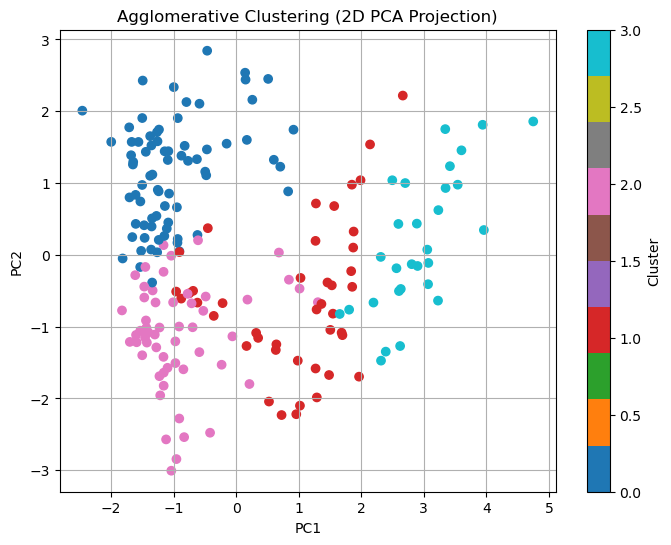

In [76]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=df["cluster"], cmap="tab10")
plt.title("Agglomerative Clustering (2D PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


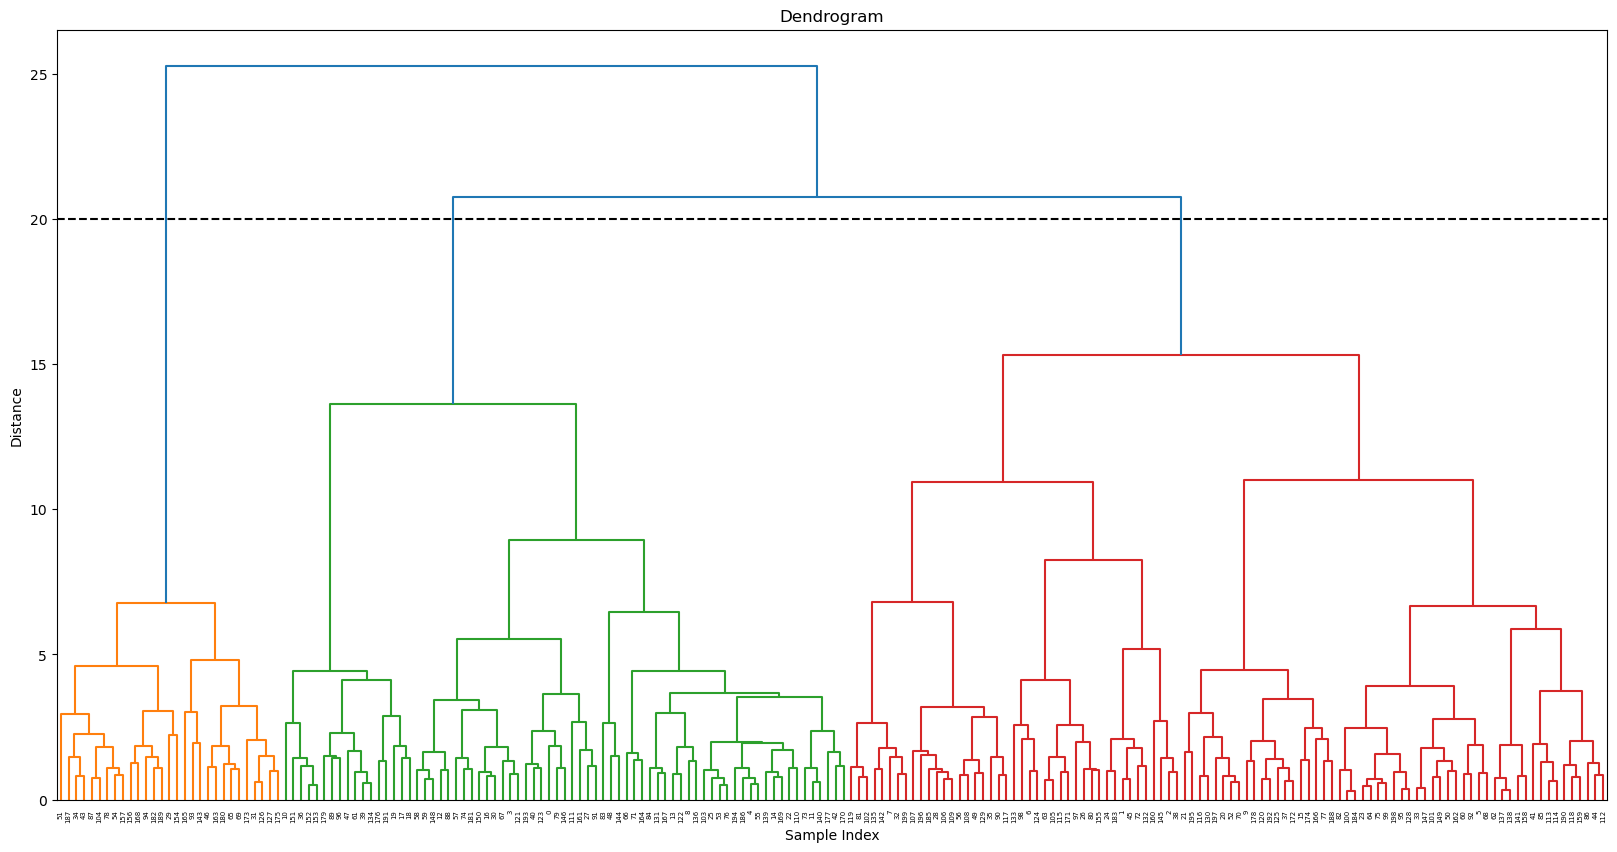

In [ ]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(20, 10))
Z = sch.linkage(features, method="ward")
threshold = 20
dendrogram = sch.dendrogram(Z)
plt.axhline(y=threshold, color='black', linestyle='--')
plt.title("Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


In [78]:
from scipy.cluster.hierarchy import fcluster

# `t` is your threshold — the height to cut the dendrogram
cluster_ids = fcluster(Z, t=threshold, criterion='distance')
df['cluster_id'] = cluster_ids
df.to_csv(os.path.join(src_dest, 'clustered.csv'), sep=';', index=False)


Index(['garbage', 'multi', 'single', 'x_grad', 'y_grad', 'grad', 'std_grad'], dtype='object')


C:\Users\swann\AppData\Local\Temp\ipykernel_30852\1708169186.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_id', y=feature, palette='tab10', ax=axis[feature_id])
C:\Users\swann\AppData\Local\Temp\ipykernel_30852\1708169186.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_id', y=feature, palette='tab10', ax=axis[feature_id])
C:\Users\swann\AppData\Local\Temp\ipykernel_30852\1708169186.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster_id', y=feature, palette='tab10', ax=a

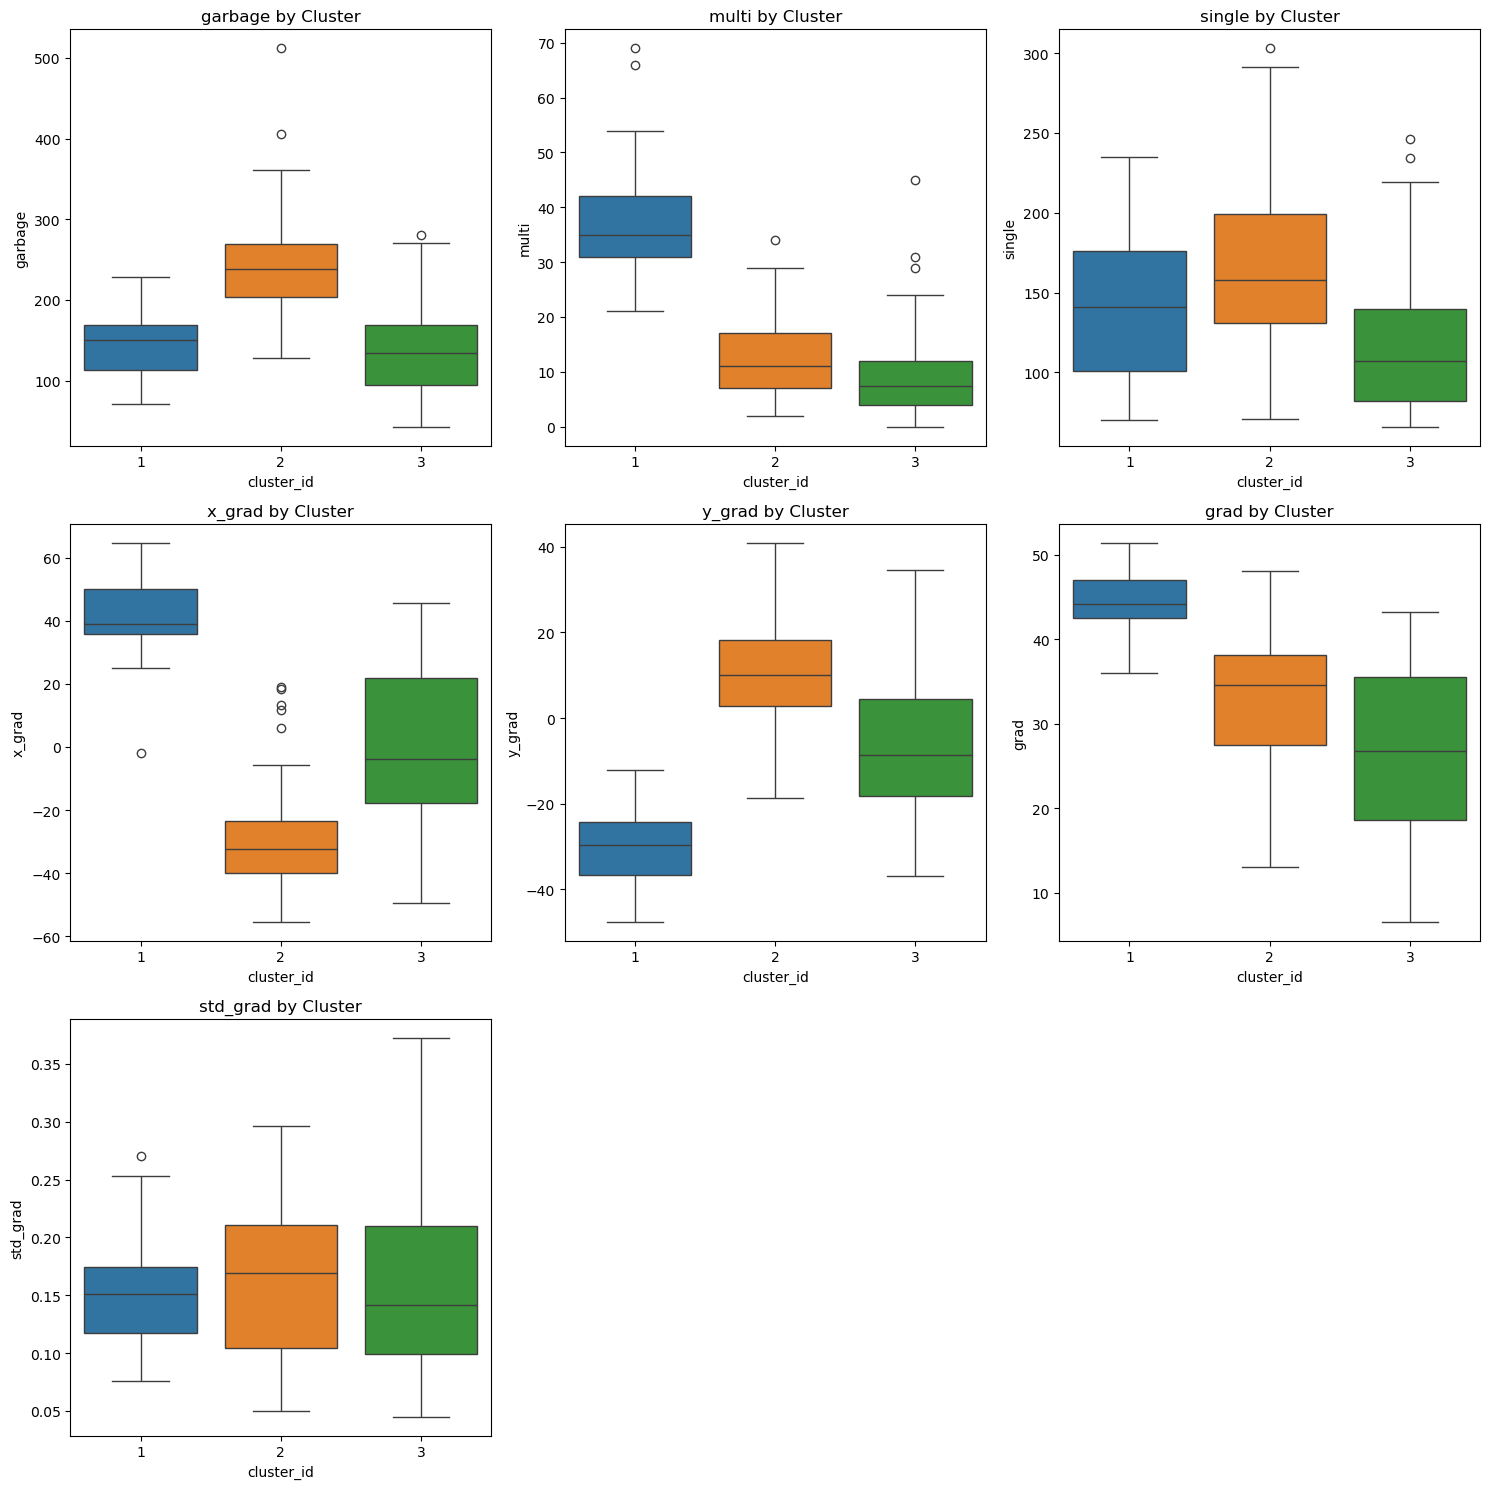

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

lst_features = df.drop(['tile_name', 'cluster_id','cluster'], axis=1).columns

print(lst_features)
fig, axis = plt.subplots(3,3, figsize=(15,15))
axis = axis.flatten()
for feature_id, feature in enumerate(lst_features):
    sns.boxplot(data=df, x='cluster_id', y=feature, palette='tab10', ax=axis[feature_id])
    axis[feature_id].set_title(f'{feature} by Cluster')
for ax_id in [x for x in range(len(axis)) if x >= len(lst_features)]:
    axis[ax_id].set_axis_off()
plt.tight_layout()
plt.show()